Lets load all images and display 

we will first import the lib


In [1]:
import numpy as np
import cv2
import os, glob
import matplotlib.pyplot as plt


Below function will display all the function from image location


In [2]:
def showImages(images, cmap=None):
    cols = 2
    rows = (len(images) + 1)
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        cmap = 'gray' if len(image.shape) == 2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

lets show all the images metnion in test_images folder


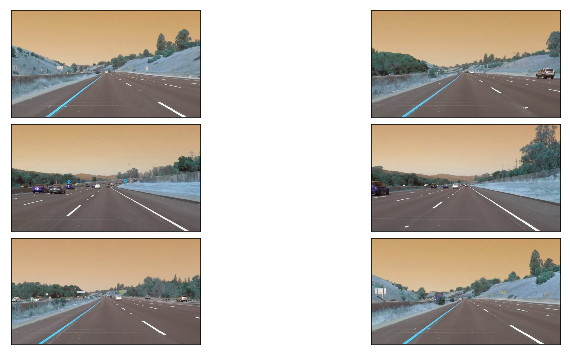

In [3]:
lane_images = []
test_images = [cv2.imread(path) for path in glob.glob('test_images/*.jpg')]
showImages(test_images) 

below function will detect edge using canny Algo 


In [4]:
def cannyAlgo(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur, 50, 150)
    return canny

lets display all the images using canny algo to detect edge 

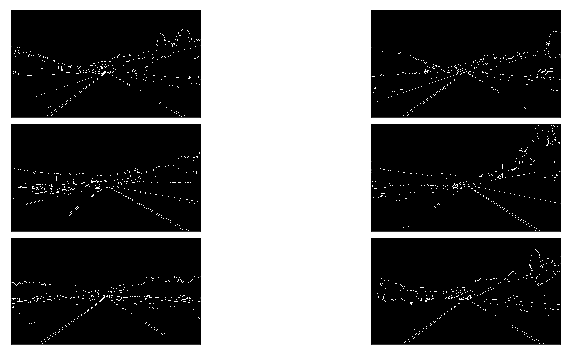

In [5]:
cannyimages = []
for image in test_images:
    cannyimages.append(cannyAlgo(image))
showImages(cannyimages)  

now we need to select the region to drwa the lines on left and right lane.below function will masked image. it will disply the line on this are and rest of the image will be replace with 0


In [6]:
def regionSelectInLane(image):
    imshape = image.shape
    poly = np.array([[(20, imshape[0]), (450, 310),
                          (490, 310), (imshape[1], imshape[0])]], dtype=np.int32)
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, poly, 255)
    maskedImage = cv2.bitwise_and(image, mask)
    return maskedImage

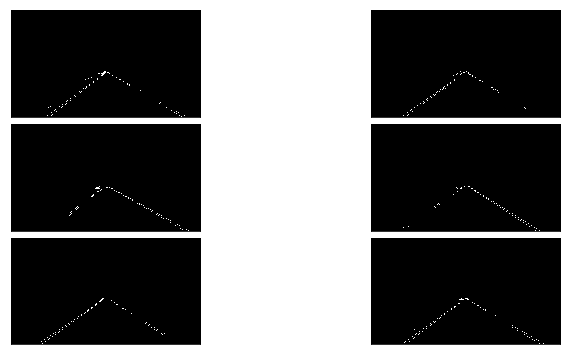

In [7]:
regionimages = []
for image in cannyimages:
    regionimages.append(regionSelectInLane(image))
showImages(regionimages)  

In [8]:
#below function calculate avg slop on both line and also drwa the points 
def avgSlope(image, lines):
    leftLine = []
    left_weights = []  # (length,)
    rightLine = []
    right_weights = []  # (length,)
    
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
        length = np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
        if slope < 0:
            leftLine.append((slope, intercept))
            left_weights.append((length))
        else:
            rightLine.append((slope, intercept))
            right_weights.append((length))
            
    left_lane = np.dot(left_weights, leftLine) / np.sum(left_weights)  if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, rightLine) / np.sum(right_weights) if len(right_weights) > 0 else None        
    y1 = image.shape[0]
    y2 = y1 * 0.6
    left_line = make_line_points(y1, y2, left_lane)
    right_line = make_line_points(y1, y2, right_lane)
    return np.array([left_line, right_line])


def make_line_points(y1, y2, line):
    """
    Convert a line represented in slope and intercept into pixel points
    """
    if line is None:
        return None
    
    slope, intercept = line
    
    # make sure everything is integer as cv2.line requires it
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return np.array([x1, y1, x2, y2])


In [9]:
def displayLines(image, lines):
    lineImage1 = np.zeros_like(image)
    if lines is None:
        print(lines)
    else: 
        try:
            for line in lines:
                x1, y1, x2, y2 = line.reshape(4)
                cv2.line(lineImage1, (x1, y1), (x2, y2), (255, 0, 255), 10)
        except AttributeError:
            print("shape not found")
    return lineImage1


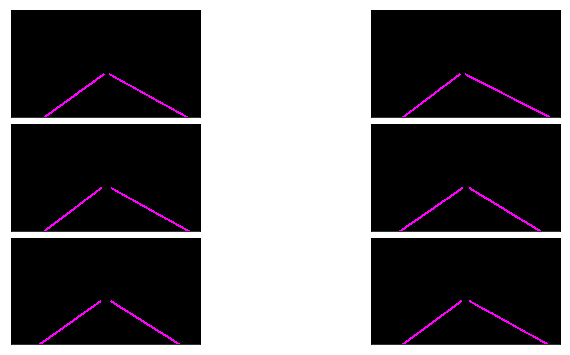

In [10]:
markedimages = []
for image,testImage in zip(regionimages,test_images):
    lines = cv2.HoughLinesP(image, 2, np.pi / 180, 15, np.array([]), minLineLength=5, maxLineGap=2)
    avgLines = avgSlope(testImage, lines)
    markedimages.append(displayLines(testImage, avgLines))
showImages(markedimages)  

now we will drwa the avlove line on orginal image


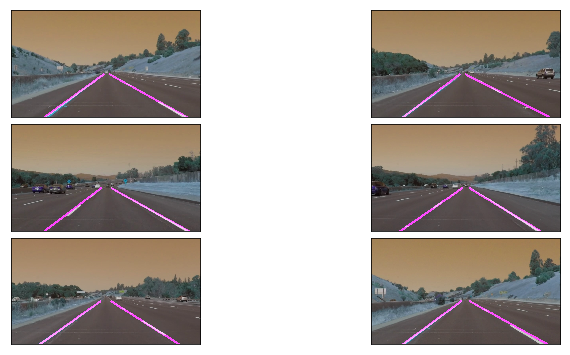

In [11]:
finalimages = []
for image,testImage in zip(markedimages,test_images):
    finalimages.append(cv2.addWeighted(testImage, 0.8, image, 1, 0))
showImages(finalimages)  

now let commbined all the above point in single funcation, below funcation will use the allavobe point to show lane in images


In [12]:
def drawLaneOnImage(image):
    laneImage = np.copy(image)
    canyImage = cannyAlgo(laneImage)
    cropedImage = regionSelectInLane(canyImage)
    lines = cv2.HoughLinesP(cropedImage, 2, np.pi / 180, 15, np.array([]), minLineLength=5, maxLineGap=2)
    avgLines = avgSlope(laneImage, lines)
    lineImage = displayLines(laneImage, avgLines)
    comboImage = cv2.addWeighted(image, 0.8, lineImage, 1, 0)
    return comboImage

Now lets call the avobe method to dislay line on all the testimages


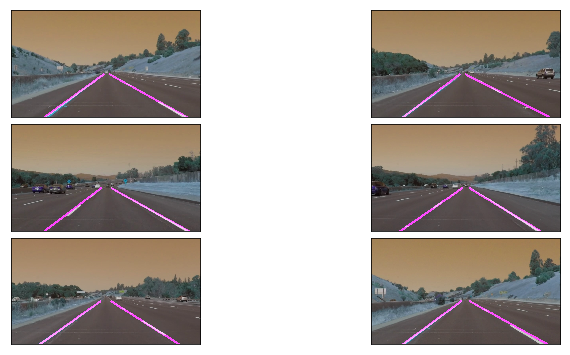

In [13]:
finalImages = []
for image in test_images:
    finalImages.append(drawLaneOnImage(image))
showImages(finalImages)